In [2]:
# Classification using image with different size and resolution（full size pooling，固定train set and test set）——2021.10.22
#import tensorflow.compat.v1 as tf
#tf.compat.v1.disable_eager_execution()
import tensorflow as tf
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt # plt 用于显示图片
from PIL import Image
#from matplotlib.pyplot import MultipleLocator
import time
#import h5py
#import cv2
#from skimage import data, io, transform, color, measure, segmentation, morphology, feature, filters # Gabor
#from skimage.feature import greycomatrix, greycoprops, local_binary_pattern # GLCM
#from sklearn.metrics import confusion_matrix # Confusion_matrix
print('loading complete')

loading complete


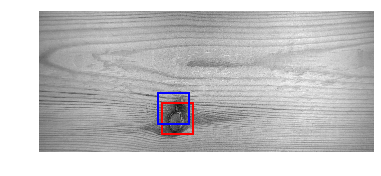

(29876, 74676, 57036, 39116, 50176, 50176, 0.40007499062617174)


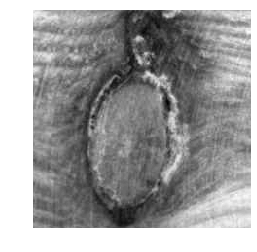

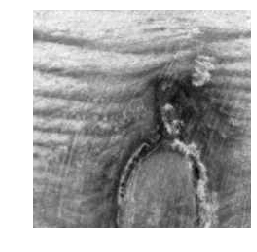

In [10]:
# data extract
p1 = mpimg.imread('E:\文件管理\木材工业研究所\manuscript-2020.05.27\待测图像2\wood_image23.jpg')
r = 224
m = 650
n = 870
#fig = plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(p1, cmap = 'gray')
rect = plt.Rectangle((n, m), r, r, fill = False, linewidth = 2, edgecolor = 'red')
b1 = np.array([[m, n], [m + r, n + r]])
ax.add_patch(rect)
m1 = 580
n1 = 840
r1 = 224
c1 = 224
rect = plt.Rectangle((n1, m1), c1, r1, fill = False, linewidth = 2, edgecolor = 'blue')
b2 = np.array([[m1, n1], [m1 + r1, n1 + c1]])
ax.add_patch(rect)
plt.axis('off') # 不显示坐标轴
#plt.imshow(p1, cmap = 'gray')
plt.show()
ratio = IoU_cmp(b1, b2)

print(ratio)

gt = p1[m:m + r, n:n + r]
plt.imshow(gt, cmap = 'gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
gt = p1[m1:m1 + r1, n1:n1 + c1]
plt.imshow(gt, cmap = 'gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()


In [14]:
# train set preperation
t = np.zeros([400, r, r, 1], dtype = np.float32)
k = 0
for i in range(20):
    x = 280 + 2 * i
    for j in range(20):
        y = 840 + 2 * j
        t[k, :, :, 0] = p1[x:x + r1, y:y + c1]
        k = k + 1
x_train_2 = t     
print(t.shape)
time.asctime()

(400, 224, 224, 1)


'Wed Nov 24 11:19:12 2021'

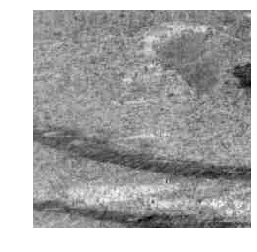

In [15]:
plt.imshow(x_train_2[300, :, :, 0], cmap = 'gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [3]:
# sample set preperation(int to float, reshape to 4D tensor)
def ReLU(x):
    y = np.maximum(0, x)
    return y
def IoU_cmp(c1, c2):
    # c1, c2 are coordinates of two boxes
    a1 = ReLU(c2[1, 0] - c1[0, 0]) * ReLU(c2[1, 1] - c1[0, 1])
    a2 = ReLU(c1[1, 0] - c2[0, 0]) * ReLU(c1[1, 1] - c2[0, 1])
    a3 = ReLU(c1[1, 0] - c2[0, 0]) * ReLU(c2[1, 1] - c1[0, 1])
    a4 = ReLU(c2[1, 0] - c1[0, 0]) * ReLU(c1[1, 1] - c2[0, 1])
    a5 = ReLU(c1[1, 0] - c1[0, 0]) * ReLU(c1[1, 1] - c1[0, 1]) # area of c1
    a6 = ReLU(c2[1, 0] - c2[0, 0]) * ReLU(c2[1, 1] - c2[0, 1]) # area of c2
    a = np.array([a1, a2, a3, a4, a5, a6])
    y1 = a.min()
    y2 = a.max()
    y3 = y1 / y2
    return a1, a2, a3, a4, a5, a6, y3
x1 = np.array([[1, 2], [10, 28]])
x2 = np.array([[8, 22], [17, 41]])
print(x1)
print(x2)
print(IoU_cmp(x1, x2))
time.asctime()

[[ 1  2]
 [10 28]]
[[ 8 22]
 [17 41]]
(624, 12, 78, 96, 234, 171, 0.019230769230769232)


'Wed Nov 24 11:15:05 2021'

(800, 224, 224, 1)
(800, 1, 1, 2)
[[[[1. 0.]]]


 [[[1. 0.]]]


 [[[1. 0.]]]


 [[[1. 0.]]]


 [[[1. 0.]]]


 [[[0. 1.]]]


 [[[0. 1.]]]


 [[[0. 1.]]]


 [[[0. 1.]]]


 [[[0. 1.]]]]


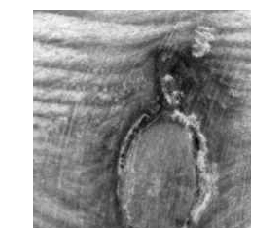

In [16]:
x_train = np.concatenate((x_train_1, x_train_2), 0)
print(x_train.shape)
y_train = np.zeros([800, 1, 1, 2], dtype = np.float32)
y_train[0:400] = np.array([1, 0])
y_train[400:800] = np.array([0, 1])
print(y_train.shape)
print(y_train[395:405])
plt.imshow(x_train[300, :, :, 0], cmap = 'gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [17]:
# parameter computing(for train)
val = x_train.shape
mb_size = 30
Z_dim = 256 * 2
X_dim = x_train.shape[3]
Y_dim = y_train.shape[3]
print('X_dim:', X_dim)
print('Y_dim:', Y_dim)
print(val)
print(y_train.shape)

X_dim: 1
Y_dim: 2
(800, 224, 224, 1)
(800, 1, 1, 2)


In [18]:
############## kernel unit #############
# func: inception creation
def inception_unit(inls, outls, a1, a2, a3):
    # inls-number of input layers
    # outls-number of output layers
    out1 = int(outls * a1)
    out2 = int(outls * a2)
    out3 = int(outls * a3)
    out4 = outls - out1 -  out2 - out3
    v = [0 for i in range(8)] # initiate a list of 8 elements
    v[0] = tf.Variable(tf.truncated_normal((1, 1, inls, out1), stddev = 0.1), dtype = tf.float32, name = 'v0') # 1x1
    v[1] = tf.Variable(tf.truncated_normal((1, 1, inls, int(out2 / 2)), stddev = 0.1), dtype = tf.float32, name = 'v1') # 3x3
    v[2] = tf.Variable(tf.truncated_normal((3, 3, int(out2 / 2), out2), stddev = 0.1), dtype = tf.float32, name = 'v2')
    v[3] = tf.Variable(tf.truncated_normal((1, 1, inls, int(out3 / 2)), stddev = 0.1), dtype = tf.float32, name = 'v3') # 5x5
    v[4] = tf.Variable(tf.truncated_normal((5, 5, int(out3 / 2), out3), stddev = 0.1), dtype = tf.float32, name = 'v4')
    v[5] = tf.Variable(tf.truncated_normal((1, 1, inls, out4), stddev = 0.1), dtype = tf.float32, name = 'v5') # maxpool
    v[6] = tf.Variable(tf.constant(0.01, shape = [outls]), dtype = tf.float32, name = 'v6')
    v[7] = tf.Variable(tf.constant(0.01, shape = [outls]), dtype = tf.float32, name = 'v7')
    # data counting
    for i in range(len(v)):
        sh = v[i].shape
        for j in range(len(sh)):
            if j == 0:
                acm = sh[j]
            if j > 0:
                acm = sh[j] * acm
        if i == 0:
            ttl = acm
        if i > 0:
            ttl = ttl + acm
    print('inception unit data:', ttl)
    return v

# func: residual network unit creation(for generation network)
def residual_unit_G(inls, outls, win):
    # inls-number of input layers
    # outls-number of output layers
    v = [0 for i in range(15)] # initiate a list of 15 elements
    v[0] = tf.Variable(tf.truncated_normal((1, 1, int(outls / 4), inls), stddev = 0.1), dtype = tf.float32, name = 'v0')
    v[1] = tf.Variable(tf.constant(0.01, shape = [int(outls / 4)]), dtype = tf.float32, name = 'v1')
    v[2] = tf.Variable(tf.constant(0.01, shape = [int(outls / 4)]), dtype = tf.float32, name = 'v2')
    v[3] = tf.Variable(tf.truncated_normal((win, win, outls, int(outls / 4)), stddev = 0.1), dtype = tf.float32, name = 'v3')
    v[4] = tf.Variable(tf.constant(0.01, shape = [outls]), dtype = tf.float32, name = 'v4')
    v[5] = tf.Variable(tf.constant(0.01, shape = [outls]), dtype = tf.float32, name = 'v5')
    v[6] = tf.Variable(tf.truncated_normal((1, 1, int(outls / 4), outls), stddev = 0.1), dtype = tf.float32, name = 'v6')
    v[7] = tf.Variable(tf.constant(0.01, shape = [int(outls / 4)]), dtype = tf.float32, name = 'v7')
    v[8] = tf.Variable(tf.constant(0.01, shape = [int(outls / 4)]), dtype = tf.float32, name = 'v8')
    v[9] = tf.Variable(tf.truncated_normal((3, 3, int(outls / 4), int(outls / 4)), stddev = 0.1), dtype = tf.float32, name = 'v9')
    v[10] = tf.Variable(tf.constant(0.01, shape = [int(outls / 4)]), dtype = tf.float32, name = 'v10')
    v[11] = tf.Variable(tf.constant(0.01, shape = [int(outls / 4)]), dtype = tf.float32, name = 'v11')
    v[12] = tf.Variable(tf.truncated_normal((1, 1, outls, int(outls / 4)), stddev = 0.1), dtype = tf.float32, name = 'v12')
    v[13] = tf.Variable(tf.constant(0.01, shape = [outls]), dtype = tf.float32, name = 'v13')
    v[14] = tf.Variable(tf.constant(0.01, shape = [outls]), dtype = tf.float32, name = 'v14')
    # data counting
    for i in range(len(v)):
        sh = v[i].shape
        for j in range(len(sh)):
            if j == 0:
                acm = sh[j]
            if j > 0:
                acm = sh[j] * acm
        if i == 0:
            ttl = acm
        if i > 0:
            ttl = ttl + acm
    print('residual unit data:', ttl)
    return v
# func: convolutional layer creation
def convolutional_unit(inls, outls, win):
    # inls-number of input layers
    # outls-number of output layers
    v = [0 for i in range(3)] # initiate a list of 3 elements
    v[0] = tf.Variable(tf.truncated_normal((win, win, inls, outls), stddev = 0.1), dtype = tf.float32, name = 'v0')
    v[1] = tf.Variable(tf.constant(0.01, shape = [outls]), dtype = tf.float32, name = 'v1')
    v[2] = tf.Variable(tf.constant(0.01, shape = [outls]), dtype = tf.float32, name = 'v2')
    # data counting
    for i in range(len(v)):
        sh = v[i].shape
        for j in range(len(sh)):
            if j == 0:
                acm = sh[j]
            if j > 0:
                acm = sh[j] * acm
        if i == 0:
            ttl = acm
        if i > 0:
            ttl = ttl + acm
    print('convolutional unit data:', ttl)
    return v
def convolutional_single(inls, outls, win):
    # inls-number of input layers
    # outls-number of output layers
    v = [0 for i in range(1)] # initiate a list of 3 elements
    v[0] = tf.Variable(tf.truncated_normal((win, win, inls, outls), stddev = 0.1), dtype = tf.float32, name = 'v0')
    # data counting
    for i in range(len(v)):
        sh = v[i].shape
        for j in range(len(sh)):
            if j == 0:
                acm = sh[j]
            if j > 0:
                acm = sh[j] * acm
        if i == 0:
            ttl = acm
        if i > 0:
            ttl = ttl + acm
    print('convolutional unit data:', ttl)
    return v

In [20]:
##### Variables create ########
X = tf.placeholder(tf.float32, shape = [None, val[1], val[2], X_dim], name = 'X')
print(X)
y = tf.placeholder(tf.float32, shape = [None, 1, 1, Y_dim], name = 'y') # 正向分类
print(y)
keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')
print(keep_prob)
c1 = 5
c2 = 7
deep1 = 16
deep2 = int(deep1 * 2)
deep3 = int(deep2 * 2)
deep4 = int(deep3 * 2)
deep5 = int(deep4 * 2)
deep6 = int(deep5 * 2)
eps = 1e-7
print('deep1', deep1)
print('deep6', deep6)

## network construction ##
## Discriminator ##
print('Discriminator layer 1:')
D1 = convolutional_unit(X_dim, deep1, c1) # 112
#D1 = inception_unit(X1_dim, deep5, 1/4, 1/4, 1/4) # 112
print(len(D1))
print('Discriminator layer 2:')
#D2 = inception_unit(deep5, deep4, 1/4, 1/4, 1/4)
D2 = convolutional_unit(deep1, deep2, c1) # 56
print(len(D2))
print('Discriminator layer 3:')
#D3 = inception_unit(deep4, deep3, 1/4, 1/4, 1/4)
D3 = convolutional_unit(deep2, deep3, c1) # 28
print(len(D3))
print('Discriminator layer 4:')
#D4 = inception_unit(deep3, deep2, 1/4, 1/4, 1/4)
D4 = convolutional_unit(deep3, deep4, c1) # 14
print(len(D4))
print('Discriminator layer 5:')
#D5 = inception_unit(deep2, deep1, 1/4, 1/4, 1/4)
D5 = convolutional_unit(deep4, deep5, c1) # 7
print(len(D5))
print('Discriminator layer 6:')
#D6 = inception_unit(deep1, deep1, 1/4, 1/4, 1/4) # 1
D6 = convolutional_unit(deep5, deep6, 7) # 1
print(len(D6))

print('Discriminator layer 7:')
D7 = convolutional_unit(deep6, deep6, 1) # 1
print(len(D7))
print('Discriminator layer 8:')
D8 = convolutional_unit(deep6, deep5, 1) # 1
print(len(D8))
print('Discriminator layer 9:')
D9 = convolutional_unit(deep5, deep4, 1) # 1
print(len(D9))
print('Discriminator layer 10:')
D10 = convolutional_single(deep4, Y_dim, 1) # 1
print(len(D10))
update = D1 + D2 + D3 + D4 + D5 + D6 + D7 + D8 + D9 + D10
print('total varibles:', len(update))
print('val', val)
time.asctime()

Tensor("X_1:0", shape=(?, 224, 224, 1), dtype=float32)
Tensor("y_1:0", shape=(?, 1, 1, 2), dtype=float32)
Tensor("keep_prob_1:0", dtype=float32)
deep1 16
deep6 512
Discriminator layer 1:
convolutional unit data: 432
3
Discriminator layer 2:
convolutional unit data: 12864
3
Discriminator layer 3:
convolutional unit data: 51328
3
Discriminator layer 4:
convolutional unit data: 205056
3
Discriminator layer 5:
convolutional unit data: 819712
3
Discriminator layer 6:
convolutional unit data: 6423552
3
Discriminator layer 7:
convolutional unit data: 263168
3
Discriminator layer 8:
convolutional unit data: 131584
3
Discriminator layer 9:
convolutional unit data: 33024
3
Discriminator layer 10:
convolutional unit data: 256
1
total varibles: 28
val (800, 224, 224, 1)


'Wed Nov 24 11:19:51 2021'

In [50]:
print(D1)
print(D2)

[<tf.Variable 'v0_23:0' shape=(1, 1, 1, 7) dtype=float32>, <tf.Variable 'v1_21:0' shape=(1, 1, 1, 4) dtype=float32>, <tf.Variable 'v2_21:0' shape=(3, 3, 4, 9) dtype=float32>, <tf.Variable 'v3_15:0' shape=(1, 1, 1, 2) dtype=float32>, <tf.Variable 'v4_15:0' shape=(5, 5, 2, 5) dtype=float32>, <tf.Variable 'v5_14:0' shape=(1, 1, 1, 11) dtype=float32>, <tf.Variable 'v6_14:0' shape=(32,) dtype=float32>, <tf.Variable 'v7_14:0' shape=(32,) dtype=float32>]
[<tf.Variable 'v0_24:0' shape=(1, 1, 32, 18) dtype=float32>, <tf.Variable 'v1_22:0' shape=(1, 1, 32, 7) dtype=float32>, <tf.Variable 'v2_22:0' shape=(3, 3, 7, 15) dtype=float32>, <tf.Variable 'v3_16:0' shape=(1, 1, 32, 9) dtype=float32>, <tf.Variable 'v4_16:0' shape=(5, 5, 9, 18) dtype=float32>, <tf.Variable 'v5_15:0' shape=(1, 1, 32, 13) dtype=float32>, <tf.Variable 'v6_15:0' shape=(64,) dtype=float32>, <tf.Variable 'v7_15:0' shape=(64,) dtype=float32>]


In [21]:
# D 网络，这里是一个简单的神经网络，x是输入图片向量，y是相应的label
def inception(x, W, name_in):
    ## Branch: 1x1 ##
    y1 = tf.nn.conv2d(x, W[0], strides = [1, 1, 1, 1], padding = "SAME")
    ## Branch: 3x3 ##
    y = tf.nn.conv2d(x, W[1], strides = [1, 1, 1, 1], padding = "SAME")
    y3 = tf.nn.conv2d(y, W[2], strides = [1, 1, 1, 1], padding = "SAME")
    ## Branch: 5x5 ##
    y = tf.nn.conv2d(x, W[3], strides = [1, 1, 1, 1], padding = "SAME")
    y5 = tf.nn.conv2d(y, W[4], strides = [1, 1, 1, 1], padding = "SAME")
    ## Branch: maxpool ##
    y = tf.nn.max_pool(x, ksize = [1, 3, 3, 1], strides = [1, 1, 1, 1], padding = "SAME") # maxpool
    ymax = tf.nn.conv2d(y, W[5], strides = [1, 1, 1, 1], padding = "SAME")
    #print(y1.shape, y3.shape, y5.shape, ymax.shape)
    y = tf.concat((y1, y3, y5, ymax), 3, name_in)
    ## Activation ##
    m, v = tf.nn.moments(y, [0])
    sd = W[6] * (y - m) / tf.pow((v + eps), 0.5) + W[7]
    y = tf.nn.relu(sd, name_in)
    #print(d)
    return y

def convolution2D(x, W, pad, name_in):
    y = tf.nn.conv2d(x, W[0], strides = [1, 1, 1, 1], padding = pad)
    m, v = tf.nn.moments(y, [0])
    sd = W[1] * (y - m) / tf.pow((v + eps), 0.5) + W[2]
    d = tf.nn.relu(sd, name_in)
    return d

def discriminator(x):
    ## discriminator: 1 ##
    #y = inception(x, D1, 'y1')
    y = convolution2D(x, D1, 'SAME', 'y')
    d = tf.nn.max_pool(y, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name = 'd1') # pooling 112 x 112
    print(d)
    fig1 = y # 记录图像
    ## discriminator: 2 ##
    #y = inception(d, D2, 'y')
    y = convolution2D(d, D2, 'SAME', 'y')
    d = tf.nn.max_pool(y, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name = 'd2') # pooling 56 x 56
    print(d)
    fig2 = y # 记录图像
    ## discriminator: 3 ##
    #y = inception(d, D3, 'y')
    y = convolution2D(d, D3, 'SAME', 'y')
    d = tf.nn.max_pool(y, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name = 'd3') # pooling 28 x 28
    print(d)
    fig3 = y # 记录图像
    ## discriminator: 4 ##
    #y = inception(d, D4, 'y')
    y = convolution2D(d, D4, 'SAME', 'y')
    #d4 = tf.nn.max_pool(y4, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "VALID", name = 'd4') # pooling
    d = tf.nn.max_pool(y, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name = 'd4') # pooling 14 x 14
    print(d)
    ## discriminator: 5 ##
    #d = inception(d, D5, 'd5') # 7 x 7
    y = convolution2D(d, D5, 'SAME', 'y')
    d = tf.nn.max_pool(y, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name = 'd5') # pooling 7 x 7
    print(d)
    ## discriminator: 6 ##
    #d = inception(d, D6, 'd6') # 7 x 7
    #d = tf.nn.avg_pool(y, ksize = [1, ys[1], ys[2], 1], strides = [1, 1, 1, 1], padding = "VALID", name = 'd7') # pooling 1 x 1
    d = convolution2D(d, D6, 'VALID', 'd6')
    print(d)
    ## discriminator: 7 ##
    d = convolution2D(d, D7, 'VALID', 'd7')
    print(d)
    ## discriminator: 8 ##
    d = convolution2D(d, D8, 'VALID', 'd8')
    print(d)
    ## discriminator: 9 ##
    d = convolution2D(d, D9, 'VALID', 'd9')
    print(d)
    ## discriminator: 10 ##
    y = tf.nn.conv2d(d, D10[0], strides = [1, 1, 1, 1], padding = 'VALID', name = 'y')
    prediction = tf.nn.softmax(y, name = 'prediction') # 判别结果
    print(prediction)
    return prediction, fig1, fig2, fig3

#噪声产生的函数
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size = [m, 1, 1, n])

def rand_array(Lv, Hv, num):
    sample = np.arange(Lv, Hv + 1, 1) #生成Lv到Hv的等差数列(Hv - Lv个数)
    output = np.random.rand(1, num)   #初始化输出数列
    for i in range(num):
        #print(i)
        val = np.random.rand(1) * (Hv - Lv + 1 - i)
        ind = int(np.floor(val))
        #print(val, ind, sample[ind])
        output[0, i] = sample[ind] #赋值
        sample = np.delete(sample, ind) #删除当前序号中的值
    return output
# 函数：rearrange
def array_assign(x, index): # 以index为依据重新分配x的元素
    y = np.zeros(x.shape, dtype = np.float32)
    for i in range(x.shape[0]):
        n = int(index[0, i])
        y[i, :] = x[n, :]
    return y

In [22]:
## 初始化 ##
D_pre, p1, p2, p3 = discriminator(X)
print('D_pre:', D_pre)

#discriminator
D_loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(D_pre), reduction_indices = [3]), name = 'D_loss') #D_loss 判断的损失
print(D_loss)

#D_solver = tf.train.AdamOptimizer(1e-4).minimize(D_loss, var_list = update)
D_solver = tf.train.GradientDescentOptimizer(1e-4).minimize(D_loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
#sess.run(tf.global_variables_initializer())

Tensor("d1:0", shape=(?, 112, 112, 16), dtype=float32)
Tensor("d2:0", shape=(?, 56, 56, 32), dtype=float32)
Tensor("d3:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("d4:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("d5:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("d6:0", shape=(?, 1, 1, 512), dtype=float32)
Tensor("d7:0", shape=(?, 1, 1, 512), dtype=float32)
Tensor("d8:0", shape=(?, 1, 1, 256), dtype=float32)
Tensor("d9:0", shape=(?, 1, 1, 128), dtype=float32)
Tensor("prediction:0", shape=(?, 1, 1, 2), dtype=float32)
D_pre: Tensor("prediction:0", shape=(?, 1, 1, 2), dtype=float32)
Tensor("D_loss:0", shape=(), dtype=float32)
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [26]:
val = x_train.shape
arr = rand_array(0, val[0] - 1, val[0]) # 生成随机数
x_all = array_assign(x_train, arr)
y_all = array_assign(y_train, arr)
#x_all = x_train
#x_all2 = x_train2
#y_all = y_train
print(arr[0, 0:10])
print('x shape', x_all.shape, 'y shape', y_all.shape, 'mb_size', mb_size)
N = 0 # for counting
cnt = 0
print('\033[1;31;46m%s\033[0m '% 'Ready for training!')
time.asctime()

[170. 626. 365. 672. 353. 480. 441. 182. 350. 670.]
x shape (800, 224, 224, 1) y shape (800, 1, 1, 2) mb_size 30
Ready for training! 


'Wed Nov 24 11:21:33 2021'

In [27]:
# training
s0 = time.clock()
s1 = time.clock()
for it in range(500):
    m1 = (N * mb_size) % (x_all.shape[0])
    m2 = np.min([m1 + mb_size, x_all.shape[0]])
    a1 = np.arange(m1, m2)
    m3 = 0
    m4 = np.max([m1 + mb_size - x_all.shape[0], 0])
    a2 = np.arange(m3, m4)
    b1 = a1.tolist()
    b2 = a2.tolist()
    t_idx = b1 + b2
    #print(len(t_idx), m1, m2, m3, m4)
    N = N + 1
    X_mb = x_all[t_idx]
    y_mb = y_all[t_idx]
    #result1 = sess.run([D_solver, D_loss, KL_loss, p1, p2, p3, p4, U], feed_dict = {X: X_mb, y1:y_mb, keep_prob:0.5}) # 下划线代表第一个参数没有返回值
    #result1 = sess.run([D_solver, D_loss], feed_dict = {X1: X1_mb, y:y_mb, keep_prob:1}) # discriminator训练
    result1 = sess.run([D_solver, D_loss], feed_dict = {X: X_mb, y:y_mb, keep_prob:1}) # discriminator训练
    # residual record
    if N == 1:
        r_w = np.array([result1[1]])
        #r_w1 = np.array([result1[2]])
        #r_w2 = np.array([result1[3]])
        #r_w3 = np.array([result1[4]])
    if N > 1:
        r_w = np.concatenate((r_w, np.array([result1[1]])), 0)
        #r_w1 = np.concatenate((r_w1, np.array([result1[2]])), 0)
        #r_w2 = np.concatenate((r_w2, np.array([result1[3]])), 0)
        #r_w3 = np.concatenate((r_w3, np.array([result1[4]])), 0)
    #输出训练时的参数
    if (it + 1) % 10 == 0:
        print('No. ', N)
        print('Iter: {}'.format(it + 1))
        print('size:', X1_mb.shape[0])
        print('Interval:', m1, m2, m3, m4)
        print('D_loss: {:.4}'.format(result1[1]))
        #print('D_loss1: {:.4}'.format(result1[2]))
        #print('D_loss2: {:.4}'.format(result1[3]))
        #print('D_loss3: {:.4}'.format(result1[4]))
        s2 = time.clock()
        print("Time used:", s2 - s1)
        s1 = time.clock()
    #axis_y = result1[10][1, :, :, 0:30] # u的柱状图
    #print(axis_y.shape)
    #axis_y = axis_y.reshape(30)
    #axis_x = np.arange(30)
    #print(axis_x.shape, axis_y.shape)
    #plt.bar(axis_x, axis_y, align = 'center')
    #plt.axis('on') # 不显示坐标轴
s3 = time.clock()
if cnt == 0:
    ttm = (s3 - s0) / 60
if cnt > 0:
    ttm = ttm + (s3 - s0) / 60
print("Time used(min):", (s3 - s0) / 60)
print("Total time(min):", ttm)
cnt = cnt + 1

rs = r_w.shape
print("r_w:", rs)
# ploting
axis_x = np.arange(1, rs[0] + 1, 1)
axis_y = r_w
plt.plot(axis_x, axis_y)
#axis_y = r_w1
#plt.plot(axis_x, axis_y)
#axis_y = r_w2
#plt.plot(axis_x, axis_y)
#axis_y = r_w3
#plt.plot(axis_x, axis_y)
x_major_locator = MultipleLocator(500)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
#plt.xticks(axis_x) #
plt.show()
time.asctime()

No.  10
Iter: 10
size: 30
Interval: 270 300 0 0
D_loss: 0.6922
Time used: 65.2061266
No.  20
Iter: 20
size: 30
Interval: 570 600 0 0
D_loss: 0.6936
Time used: 69.24192040000001
No.  30
Iter: 30
size: 30
Interval: 70 100 0 0
D_loss: 0.6917
Time used: 70.69621080000002
No.  40
Iter: 40
size: 30
Interval: 370 400 0 0
D_loss: 0.6927
Time used: 68.96821059999996
No.  50
Iter: 50
size: 30
Interval: 670 700 0 0
D_loss: 0.6917
Time used: 73.04412839999998
No.  60
Iter: 60
size: 30
Interval: 170 200 0 0
D_loss: 0.6916
Time used: 71.88246579999998
No.  70
Iter: 70
size: 30
Interval: 470 500 0 0
D_loss: 0.6891
Time used: 72.67899919999996
No.  80
Iter: 80
size: 30
Interval: 770 800 0 0
D_loss: 0.6913
Time used: 72.1001566000001
No.  90
Iter: 90
size: 30
Interval: 270 300 0 0
D_loss: 0.6886
Time used: 72.0669696000001
No.  100
Iter: 100
size: 30
Interval: 570 600 0 0
D_loss: 0.6895
Time used: 71.05545510000002
No.  110
Iter: 110
size: 30
Interval: 70 100 0 0
D_loss: 0.6877
Time used: 73.4435108000

NameError: name 'MultipleLocator' is not defined

In [19]:
# results saving
np.save('residual_self', r_w)
#np.save('residual_self_branch_1', r_w)
#np.save('residual_self_branch_2', r_w1)
#np.save('residual_self_branch_3', r_w2)
#np.save('residual_self_branch_4', r_w3)

[275. 219. 435. 441.  94.  43. 312. 509. 281.  95.] (800, 224, 224, 1) (800, 1, 1, 2)


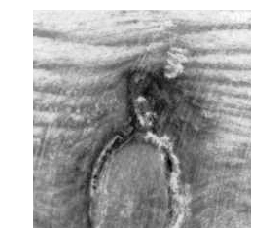

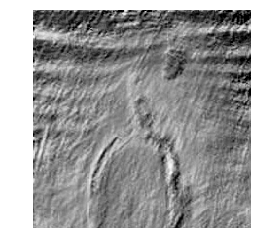

i: 1 j: 1


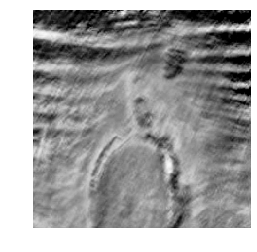

i: 1 j: 2


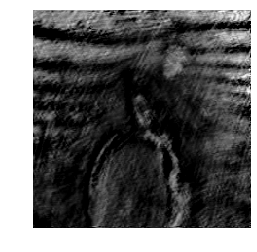

i: 1 j: 3


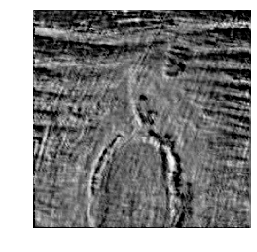

i: 1 j: 4
(100, 1, 1) Tensor("ArgMax_2:0", shape=(100, 1, 1), dtype=int64) Tensor("ArgMax_3:0", shape=(100, 1, 1), dtype=int64)
()
acc 1.0
accuracy:  1.0
y_pre (100, 1, 1)
y_real (100, 1, 1)
number of samples 800
1 1


'Wed Nov 24 16:11:11 2021'

In [32]:
# testing
val2 = x_train.shape
arr = rand_array(0, val2[0] - 1, val2[0]) # 生成随机数
print(arr[0, 0:10], x_train.shape, y_train.shape)

x_total = array_assign(x_train, arr)
y_total = array_assign(y_train, arr)
a1 = 0
a2 = a1 + 100
def compute_accuracy(v_xs1, v_ys):
    y_pre = sess.run([D_pre, p1, p2, p3], feed_dict = {X: v_xs1, y:v_ys, keep_prob:1}) # discriminator训练
    nn = 4 # image No.
    
    ofd = 0 # feafure No.
    No = '18' # class No.(for image saving)
    show_en = 1
    save_en = 0
    if show_en == 1:
        img = v_xs1[nn, :, :, 0]
        plt.imshow(img, cmap = 'Greys_r') # sample image display
        area = np.pi * 2**2
        plt.axis('off') # 不显示坐标轴
        plt.show()
        if save_en == 1:
            mpimg.imsave('x_' + No + '_%d.jpg'%(0), img, cmap = 'Greys_r')
        k = 0
        for i in range(1): # index for level of feature map
            sp = y_pre[i + 1].shape # acquire dimension of feature map
            for j in range(4): # index for type of feature map(4 types in this test)
                k = k + 1
                img = y_pre[i + 1][nn, :, :, int(sp[3] / 4) * j + ofd]
                plt.imshow(img, cmap = 'Greys_r') # feature map display
                plt.axis('off') # 不显示坐标轴
                plt.show()
                print('i:', i + 1, 'j:', j + 1)
                if save_en == 1:
                    mpimg.imsave('x_' + No + '_%d.jpg'%(k), img, cmap = 'Greys_r')
    #print(y_pre[0].shape, v_ys.shape)
    pre = tf.argmax(y_pre[0], 3)
    rel = tf.argmax(v_ys, 3)
    correct_prediction = tf.equal(pre, rel)
    print(correct_prediction.shape, pre, rel)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(accuracy.shape)
    result = sess.run([accuracy, pre, rel], feed_dict = {X: v_xs1, y:v_ys}) # discriminator训练
    print('acc', result[0])
    return result
acc = compute_accuracy(x_total[a1:a2], y_total[a1:a2])
in1 = 782
in2 = in1 + 10
#print(y_test[in1:in2])
#acc = compute_accuracy(x_test[in1:in2], y_test[in1:in2])

print('\033[1;31;46m%s\033[0m '% 'accuracy:', acc[0])
print('y_pre', acc[1].shape)
print('y_real', acc[2].shape)

print('number of samples', val2[0])
print(np.max(acc[1]), np.max(acc[2]))
time.asctime()

In [26]:
# testing all
print(val2[0])
a1 = 0
interval = 100
a2 = a1 + interval
i = 0
while a2 < val2[0]:
    a1 = i * interval # start point
    a2 = np.min([a1 + interval, val2[0]]) # end point
    acc = compute_accuracy(x_total[a1:a2], y_total[a1:a2])
    #acc = compute_accuracy(x_all[a1:a2], y_all[a1:a2])
    if i == 0:
        count = acc[0] * (a2 - a1) # number of correct results
        y_pre = acc[1] # predict vector
        y_real = acc[2] # real vector
    if i > 0:
        count = count + acc[0] * (a2 - a1)
        y_pre = np.concatenate((y_pre, acc[1]), 0)
        y_real = np.concatenate((y_real, acc[2]), 0)
    i = i + 1
    print('No.', i, 'Interval:', a1, a2)
acc_t = count / val2[0]
print(y_pre.shape)
print(y_real.shape)
print('\033[1;31;46m%s\033[0m '% 'mean accuracy:', acc_t)
time.asctime()

986
(100, 56, 56, 32)
(100, 28, 28, 64)
(100, 14, 14, 128)
(100, 7, 7, 256)
(7, 7, 256)
xm1 (7, 7, 256)
xm2 (7, 7, 256)
xm3 (7, 7, 256)
(100, 1, 1) Tensor("ArgMax_48:0", shape=(100, 1, 1), dtype=int64) Tensor("ArgMax_49:0", shape=(100, 1, 1), dtype=int64)
()
acc 0.65
No. 1 Interval: 0 100
(100, 56, 56, 32)
(100, 28, 28, 64)
(100, 14, 14, 128)
(100, 7, 7, 256)
(7, 7, 256)
xm1 (7, 7, 256)
xm2 (7, 7, 256)
xm3 (7, 7, 256)
(100, 1, 1) Tensor("ArgMax_50:0", shape=(100, 1, 1), dtype=int64) Tensor("ArgMax_51:0", shape=(100, 1, 1), dtype=int64)
()
acc 0.77
No. 2 Interval: 100 200
(100, 56, 56, 32)
(100, 28, 28, 64)
(100, 14, 14, 128)
(100, 7, 7, 256)
(7, 7, 256)
xm1 (7, 7, 256)
xm2 (7, 7, 256)
xm3 (7, 7, 256)
(100, 1, 1) Tensor("ArgMax_52:0", shape=(100, 1, 1), dtype=int64) Tensor("ArgMax_53:0", shape=(100, 1, 1), dtype=int64)
()
acc 0.67
No. 3 Interval: 200 300
(100, 56, 56, 32)
(100, 28, 28, 64)
(100, 14, 14, 128)
(100, 7, 7, 256)
(7, 7, 256)
xm1 (7, 7, 256)
xm2 (7, 7, 256)
xm3 (7, 7, 256)
(1

'Fri Oct 22 20:12:39 2021'

In [19]:
# F1-mean calculation
y_pre = y_pre.reshape(y_pre.shape[0])
y_real = y_real.reshape(y_real.shape[0])
print(type(y_real), y_real.dtype, y_real.shape, y_pre.shape, np.max(y_real))
cm = confusion_matrix(y_real, y_pre)
np.save('cm_inceptin', cm)
np.save('y_pre_inceptin', y_pre)
np.save('y_real_inceptin', y_real)
cm1 = np.sum(cm, axis = 0) # TP + FP
cm2 = np.sum(cm, axis = 1) # TP + FN
np.set_printoptions(precision = 2)
cm_normalized = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
#cm_normalized = cm
dia = np.diagonal(cm)
#print(cm, cm1, cm2)
print('precision', dia / cm1)
print('recall', dia / cm2)
print('F1', dia * 2 / (cm1 + cm2))
print('F1_mean', np.mean(dia * 2 / (cm1 + cm2)))
print(cm)

<class 'numpy.ndarray'> int64 (986,) (986,) 17
precision [0.77 0.58 0.59 0.6  0.46 0.77 0.8  0.35 0.42 0.86 0.5  0.22 0.2  0.57
 0.68 0.45 0.42 0.64]
recall [0.7  0.62 0.73 0.82 0.31 0.6  0.5  0.38 0.52 0.76 0.19 0.32 0.09 0.62
 0.8  0.41 0.55 0.43]
F1 [0.74 0.6  0.65 0.69 0.37 0.68 0.62 0.37 0.46 0.81 0.27 0.26 0.13 0.59
 0.74 0.43 0.48 0.51]
F1_mean 0.5213382739317444
[[50  5  2  0  0  0  0  0  5  3  0  1  0  0  0  1  4  0]
 [ 0 37 12  0  3  0  0  0  3  2  0  1  2  0  0  0  0  0]
 [ 1  6 44  0  0  0  0  0  1  1  1  1  1  0  0  3  0  1]
 [ 8  5  0 74  1  1  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 49 22  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  2  0  0 24  1  0  4  0  0  2  3  0  0  0  0  0]
 [ 0  4  0  0  0  1 12  0  0  0  0  3  2  0  1  1  0  0]
 [ 3  0  9  0  8  0  0 22  0  2  0  3  3  4  2  2  0  0]
 [ 3  0  1  0  0  2  0  0 23  1  0  1  0  1  1  3  5  3]
 [ 0  0  3  0  1  0  0  0  0 81  0  0  0  1  0 11 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  1  2 10  0]


<class 'numpy.ndarray'> int64 (3944,) (3944,) 17
precision [0.93 0.87 0.88 0.81 0.88 0.83 0.85 0.76 0.79 0.88 0.82 0.76 0.64 0.8
 0.87 0.77 0.82 0.66]
recall [0.88 0.89 0.88 0.92 0.72 0.9  0.77 0.78 0.77 0.91 0.73 0.68 0.72 0.65
 0.94 0.85 0.82 0.61]
F1 [0.91 0.88 0.88 0.86 0.79 0.86 0.81 0.77 0.78 0.89 0.78 0.72 0.68 0.71
 0.9  0.81 0.82 0.63]
F1_mean 0.8045237883350178


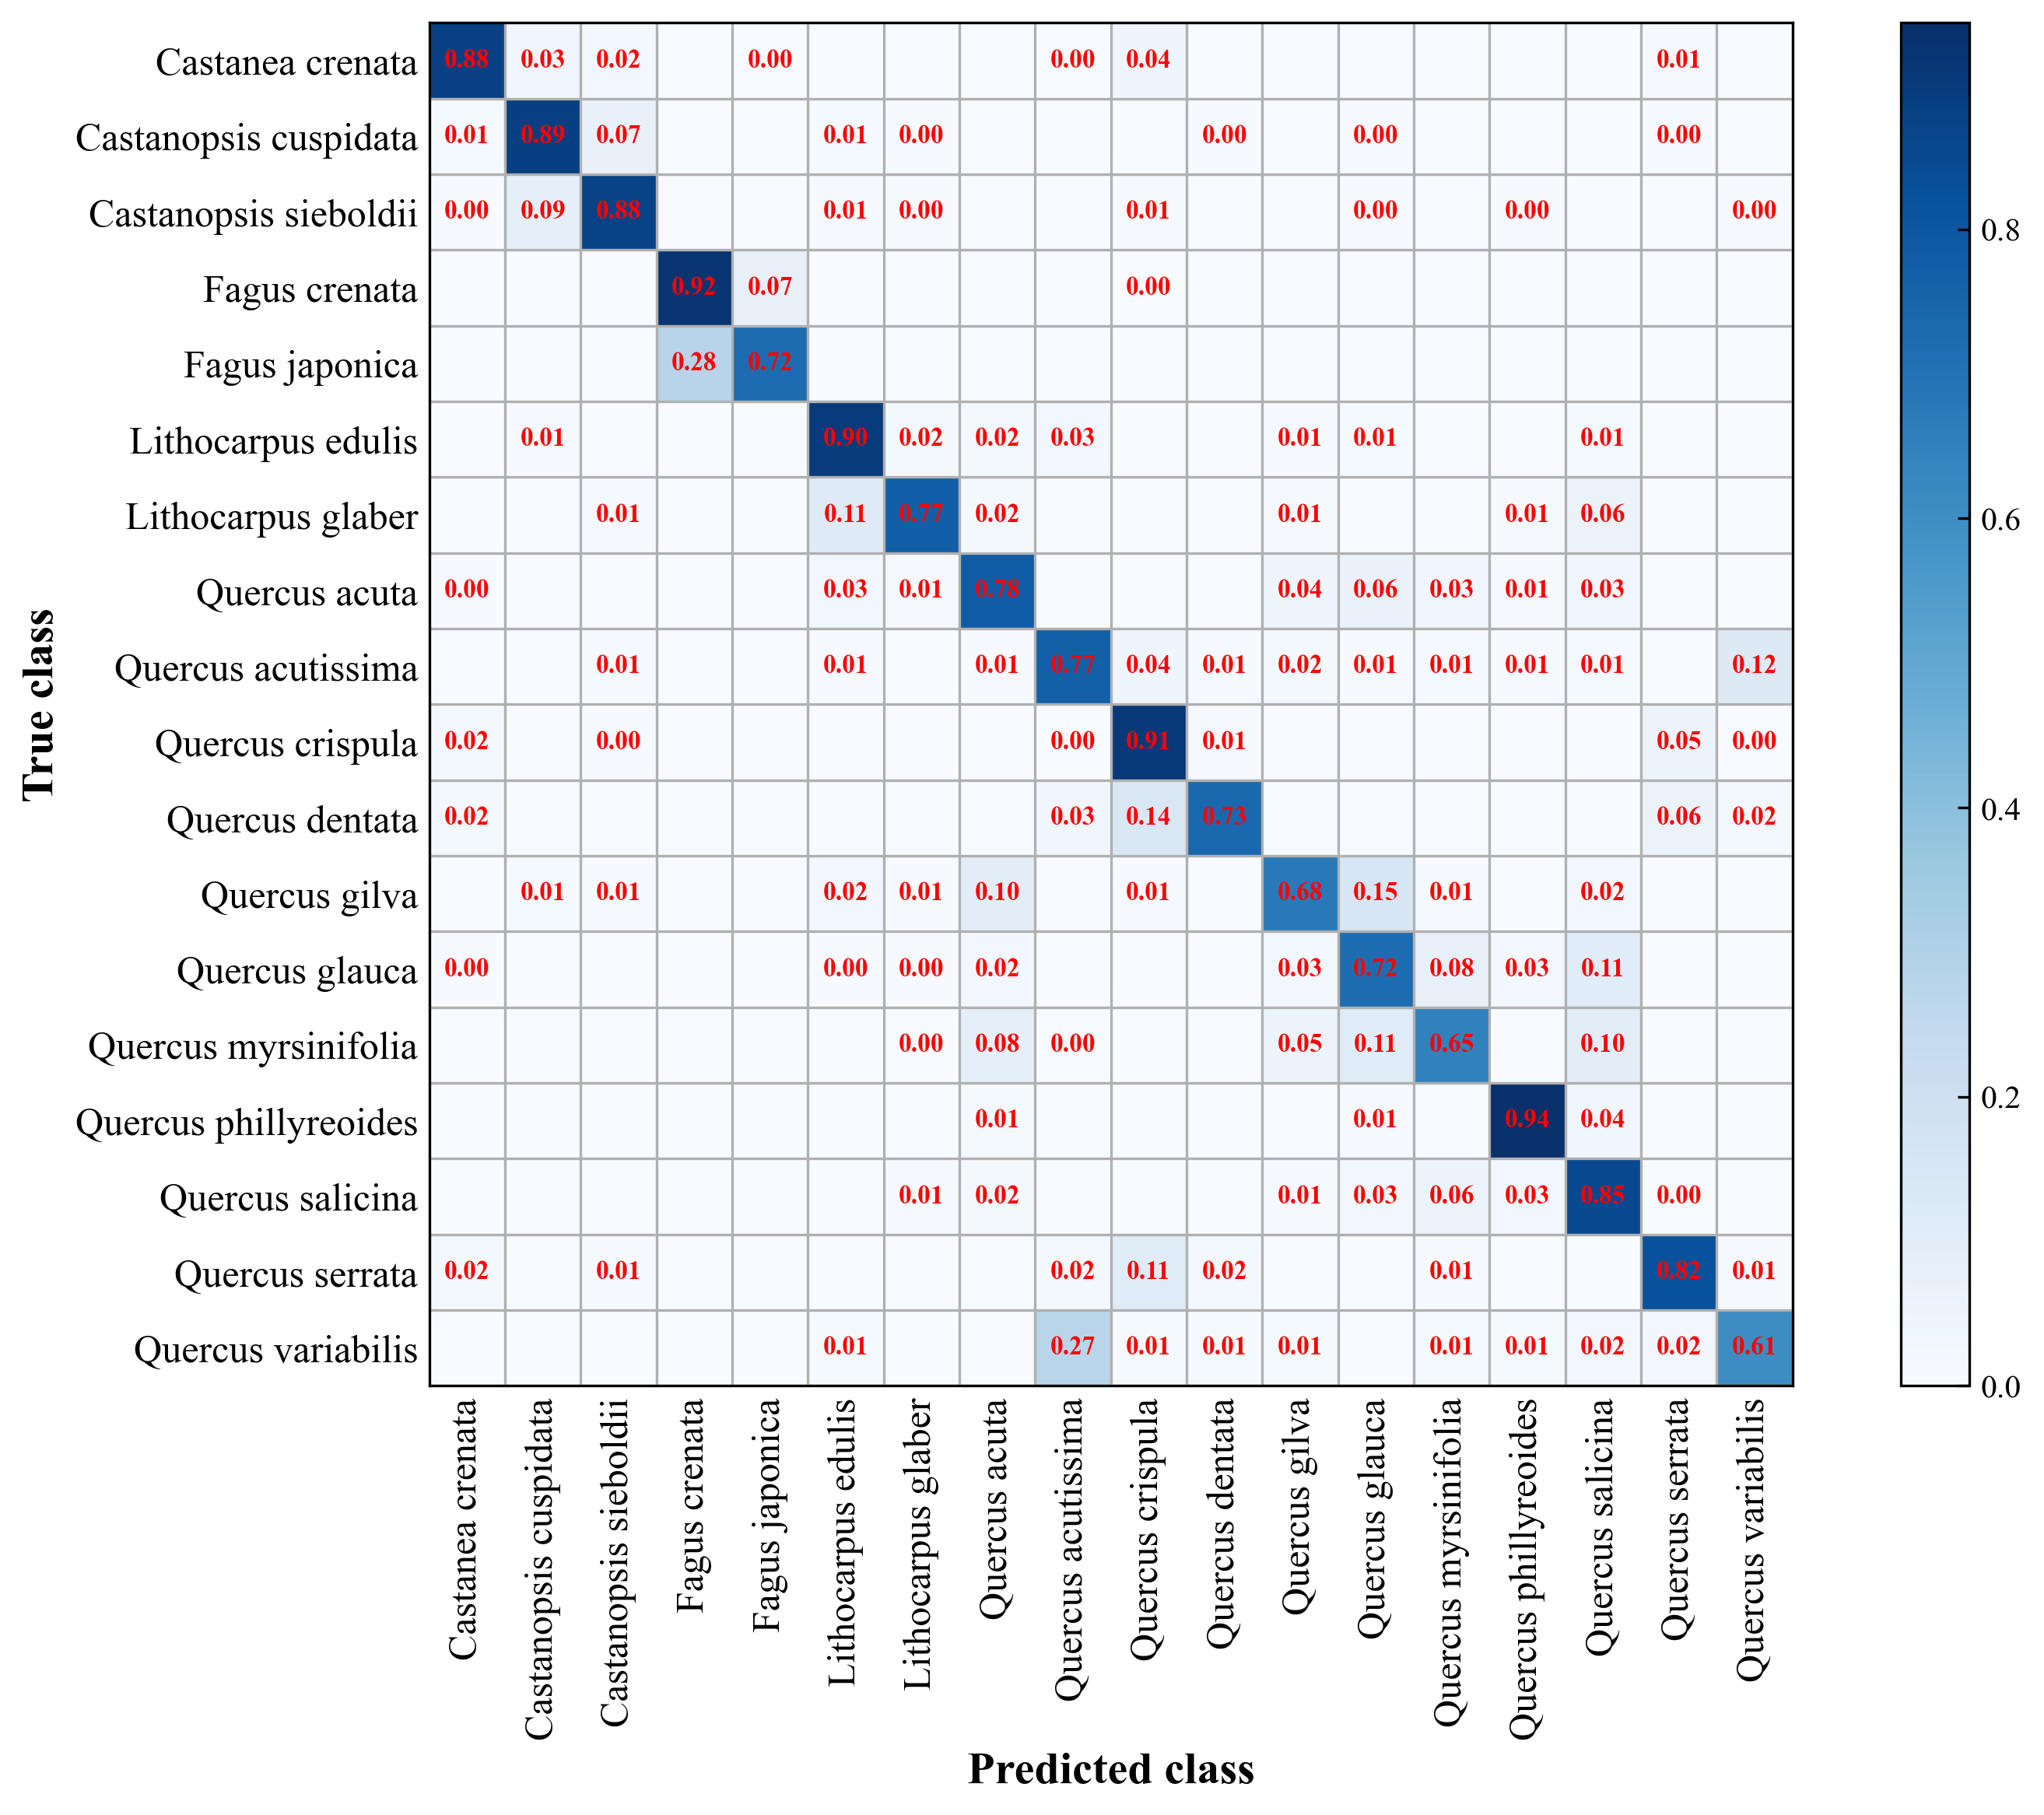

In [22]:
# confusion_matrix (Species level)
# func: matrix plotting
def plot_confusion_matrix(x, labels, title = 'Confusion Matrix'):
    plt.imshow(x, interpolation = 'nearest', cmap = 'Blues')
    #plt.title(title)
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.colorbar()
    
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation = 90)
    plt.yticks(xlocations, labels)
    font = {'family':'Times New Roman', 'weight':'bold', 'size':'larger', 'color':'black'}
    plt.ylabel('True class', fontsize = 14, fontdict = font)
    plt.xlabel('Predicted class', fontsize = 14, fontdict = font)
    plt.xticks(fontproperties = 'Times New Roman', size = 12)
    plt.yticks(fontproperties = 'Times New Roman', size = 12)
## func end
L1 = 'Castanea crenata'
L2 = 'Castanopsis cuspidata'
L3 = 'Castanopsis sieboldii'
L4 = 'Fagus crenata'
L5 = 'Fagus japonica'
L6 = 'Lithocarpus edulis'
L7 = 'Lithocarpus glaber'
L8 = 'Quercus acuta'
L9 = 'Quercus acutissima'
L10 = 'Quercus crispula'
L11 = 'Quercus dentata'
L12 = 'Quercus gilva'
L13 = 'Quercus glauca'
L14 = 'Quercus myrsinifolia'
L15 = 'Quercus phillyreoides'
L16 = 'Quercus salicina'
L17 = 'Quercus serrata'
L18 = 'Quercus variabilis'
label = [L1, L2, L3, L4, L5, L6, L7, L8, L9, L10, L11, L12, L13, L14, L15, L16, L17, L18]

tick_marks = np.array(range(len(label))) + 0.5
#y_true = acc[2]
#y_pred = acc[1]
y_pre = y_pre.reshape(y_pre.shape[0])
y_real = y_real.reshape(y_real.shape[0])
print(type(y_real), y_real.dtype, y_real.shape, y_pre.shape, np.max(y_real))
cm = confusion_matrix(y_real, y_pre)
np.save('cm_inceptin', cm)
np.save('y_pre_inceptin', y_pre)
np.save('y_real_inceptin', y_real)
cm1 = np.sum(cm, axis = 0) # TP + FP
cm2 = np.sum(cm, axis = 1) # TP + FN
np.set_printoptions(precision = 2)
cm_normalized = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
#cm_normalized = cm
dia = np.diagonal(cm)
#print(cm, cm1, cm2)
print('precision', dia / cm1)
print('recall', dia / cm2)
print('F1', dia * 2 / (cm1 + cm2))
print('F1_mean', np.mean(dia * 2 / (cm1 + cm2)))

#print('recall', t2)
F1 = 1 / t1
#print(np.sum(cm, axis = 0))


plt.figure(figsize = (12, 8), dpi = 300)

ind_array = np.arange(len(label))
x, y = np.meshgrid(ind_array, ind_array)
#print(x.shape, y)
font = {'family':'Times New Roman', 'weight':'bold', 'size':'larger'}
for x_val, y_val in zip(x.flatten(), y.flatten()):
    #print(x_val, y_val)
    c = cm_normalized[y_val][x_val]
    if c > 0.0:
        plt.text(x_val, y_val, "%0.2f" % (c,), color = 'red', font_properties = font, fontsize = 8, va = 'center', ha = 'center')

# offset the tick
plt.gca().set_xticks(tick_marks, minor = True)
plt.gca().set_yticks(tick_marks, minor = True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which = 'minor', linestyle = '-')
plt.gcf().subplots_adjust(bottom = 0.15)

plot_confusion_matrix(cm_normalized, label, title = 'Normalized confusion matrix')
#plt.savefig('Loss_plot.jpg', bbox_inches = 'tight')
plt.savefig('confusion_matrix_Species.jpg', format = 'jpg', bbox_inches = 'tight')
plt.show()

In [13]:
# Genus level accuracy comupting
b1 = 900
b2 = 930
print(y_real[b1:b2])
def StoG(x):
    # change number of Species into Genus
    # x-input vecter
    # 7-17
    y = (x > 6.9) * 4
    # 5, 6
    y1 = (x > 4.9)
    y2 = (x < 6.1)
    y = (y1 == y2) * 3 + y
    # 3, 4
    y1 = (x > 2.9)
    y2 = (x < 4.1)
    y = (y1 == y2) * 2 + y
    # 1, 2
    y1 = (x > 0.9)
    y2 = (x < 2.1)
    y = (y1 == y2) * 1 + y
    return y
y_real = StoG(y_real)
y_pre = StoG(y_pre)
# accuracy computing
Acc = (y_real == y_pre) * 1
Acc = np.sum(Acc) / val2[0]
print(y_real[b1:b2])
print(y_pre[b1:b2])
print(np.max(y_real), np.max(y_pre))
print('Acc =', Acc)

[ 7 14  2 16  2 16  9  0  7 14  7 16  5  9  7 17 12  6 15  1  3 12  0  5
  3  9 10  6  0  3]
[4 4 1 4 1 4 4 0 4 4 4 4 3 4 4 4 4 3 4 1 2 4 0 3 2 4 4 3 0 2]
[4 4 1 4 1 4 4 0 4 4 4 4 3 4 4 4 4 3 4 1 2 4 0 3 2 4 4 3 0 2]
4 4
Acc = 0.9769269776876268


<class 'numpy.ndarray'> (3944,) (3944,) 4
[[ 264    8    0    1   11]
 [  20  451    0    2    7]
 [   0    0  648    0    0]
 [   0    7    0  231   18]
 [   4    4    1    8 2259]]


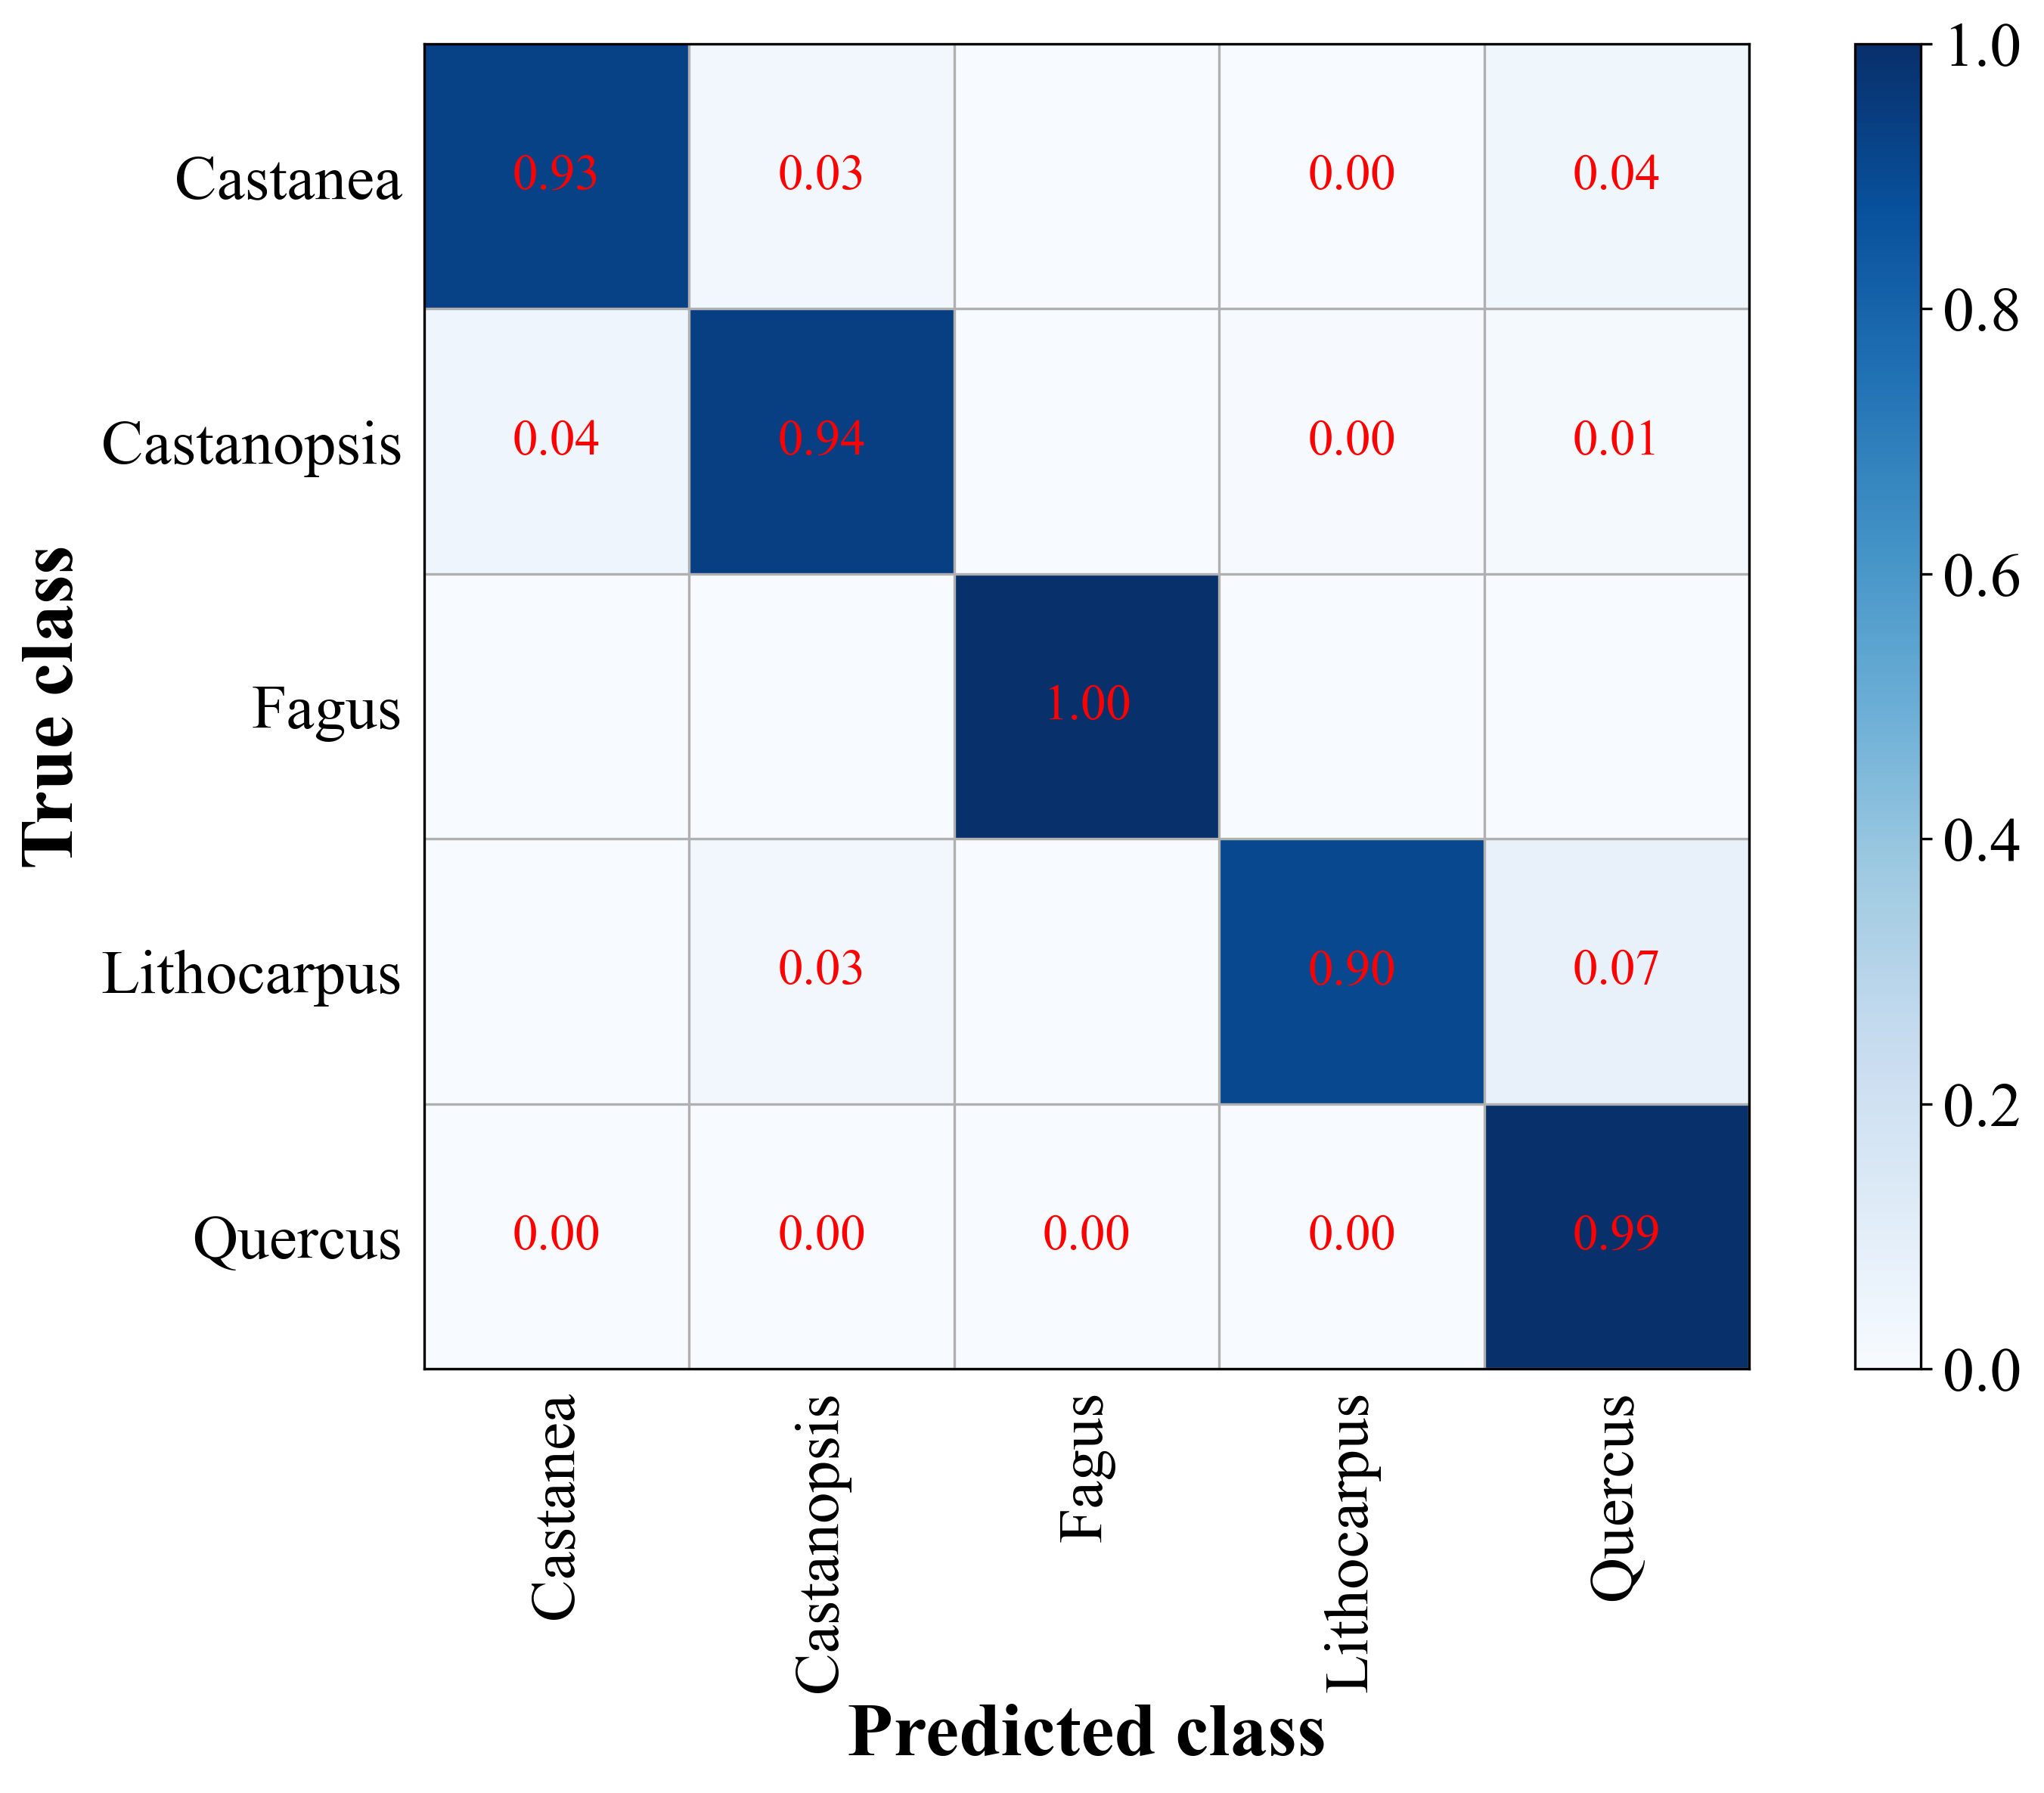

In [23]:
# confusion_matrix generation(Genus level)
def plot_confusion_matrix(x, labels, title = 'Confusion Matrix'):
    plt.imshow(x, interpolation = 'nearest', cmap = 'Blues')
    #plt.title(title)
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = '20'
    plt.colorbar()
    
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation = 90)
    plt.yticks(xlocations, labels)
    font = {'family':'Times New Roman', 'weight':'bold', 'size':'larger', 'color':'black'}
    plt.ylabel('True class', fontsize = 24, fontdict = font)
    plt.xlabel('Predicted class', fontsize = 24, fontdict = font)
    plt.xticks(fontproperties = 'Times New Roman', size = 20)
    plt.yticks(fontproperties = 'Times New Roman', size = 20)
    
label = ['Castanea', 'Castanopsis', 'Fagus', 'Lithocarpus', 'Quercus']
tick_marks = np.array(range(len(label))) + 0.5
#y_true = acc[2]
#y_pred = acc[1]
print(type(y_real), y_real.shape, y_pre.shape, np.max(y_real))
cm = confusion_matrix(y_real, y_pre)
np.set_printoptions(precision = 2)
cm_normalized = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
#cm_normalized = cm
print(cm)
plt.figure(figsize = (12, 8), dpi = 300)

ind_array = np.arange(len(label))
x, y = np.meshgrid(ind_array, ind_array)
#print(x.shape, y)
for x_val, y_val in zip(x.flatten(), y.flatten()):
    #print(x_val, y_val)
    c = cm_normalized[y_val][x_val]
    if c > 0.0:
        plt.text(x_val, y_val, "%0.2f" % (c,), color = 'red', fontsize = 16, va = 'center', ha = 'center')

# offset the tick
plt.gca().set_xticks(tick_marks, minor = True)
plt.gca().set_yticks(tick_marks, minor = True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which = 'minor', linestyle = '-')
plt.gcf().subplots_adjust(bottom = 0.15)
 
plot_confusion_matrix(cm_normalized, label, title = 'Normalized confusion matrix')
plt.savefig('confusion_matrix_Genus.jpg', format = 'jpg', bbox_inches = 'tight')
plt.show()

<class 'numpy.ndarray'> int64 (2258,) (2258,) 10
[[108   1   2   0  28  30  23  12  25   0   0]
 [  3 124   2   4   5   1   6   5   0  20   5]
 [  8   3 365   0   1   0   0   0   6  42   1]
 [  0  25   2  15   1   0   0   0   2  16   2]
 [ 13   4   0   0 132  15   7   0   3   1   0]
 [ 21   4   0   0  37  39  51   2  57   0   1]
 [ 23   3   0   0   7  22 188   2  22   1   1]
 [  8   1   0   0   1   0   1 122   7   0   0]
 [ 22   1   0   1  10  22  54   5 183   1   2]
 [  3   8  45   2   0   0   0   0   0 128   0]
 [  0  50   0   6   1   0   0   0   0   7  18]]


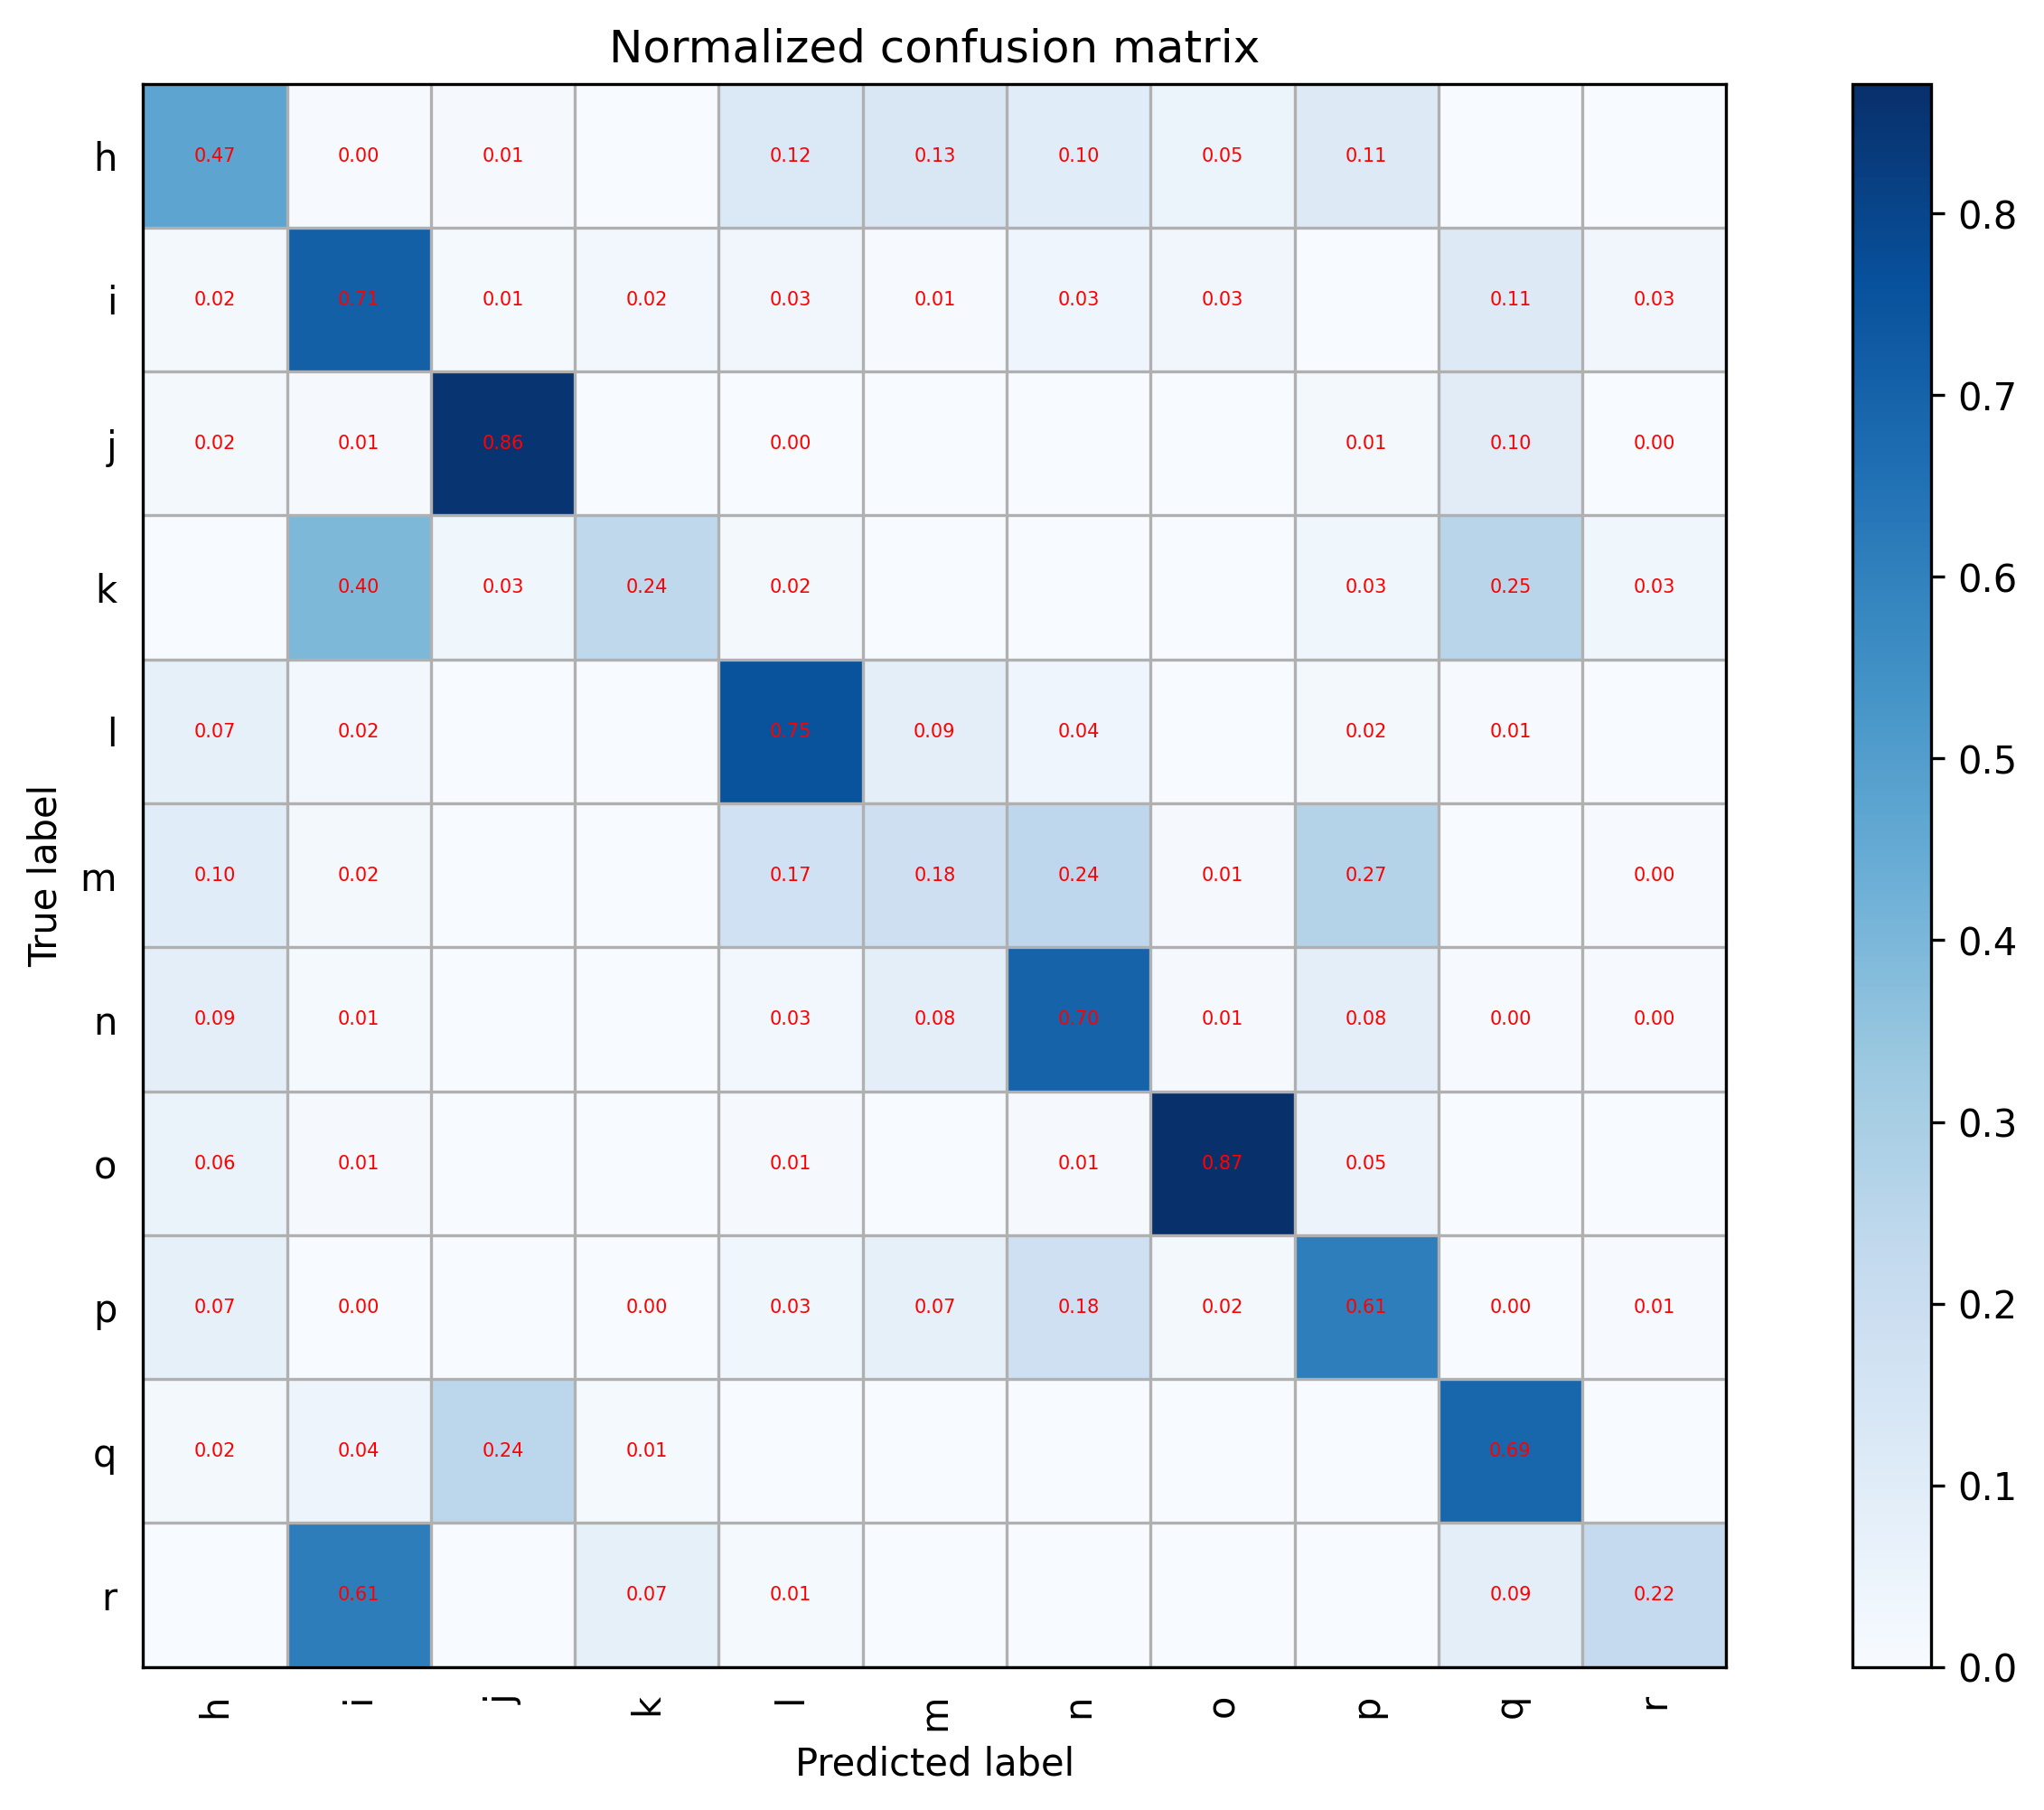

In [42]:
# confusion_matrix (Sub Species level)
label = ['h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r']
tick_marks = np.array(range(len(label))) + 0.5
#y_true = acc[2]
#y_pred = acc[1]
print(type(y_real), y_real.dtype, y_real.shape, y_pre.shape, np.max(y_real))
cm = confusion_matrix(y_real, y_pre)
np.set_printoptions(precision = 2)
cm_normalized = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
#cm_normalized = cm
print(cm)
plt.figure(figsize = (12, 8), dpi = 300)

ind_array = np.arange(len(label))
x, y = np.meshgrid(ind_array, ind_array)
#print(x.shape, y)
for x_val, y_val in zip(x.flatten(), y.flatten()):
    #print(x_val, y_val)
    c = cm_normalized[y_val][x_val]
    if c > 0.0:
        plt.text(x_val, y_val, "%0.2f" % (c,), color = 'red', fontsize = 5, va = 'center', ha = 'center')

# offset the tick
plt.gca().set_xticks(tick_marks, minor = True)
plt.gca().set_yticks(tick_marks, minor = True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which = 'minor', linestyle = '-')
plt.gcf().subplots_adjust(bottom = 0.15)
 
plot_confusion_matrix(cm_normalized, label, title = 'Normalized confusion matrix')
plt.savefig('confusion_matrix.jpg', format = 'jpg', bbox_inches = 'tight')
plt.show()

In [33]:
import matplotlib
matplotlib.image.imsave('numwood2_2.png', (x_train[1, :, :, :] + 0.0) / 1.)

In [21]:
## 模型保存 ##
saver = tf.train.Saver()
trainResultPath = 'D:/jupyterworkspace/model_self/f1'
print('saving...')
saver.save(sess, trainResultPath)

saving...


'D:/jupyterworkspace/model_self/f1'

In [8]:
## 模型加载 ##
saver = tf.train.Saver()
trainResultPath = 'D:/jupyterworkspace/model_self/f1'
saver.restore(sess, trainResultPath)# 加载到当前环境中

INFO:tensorflow:Restoring parameters from D:/jupyterworkspace/model_self/f1


In [18]:
logdir = 'E:/pythonworkspace/log'
writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
writer.close()

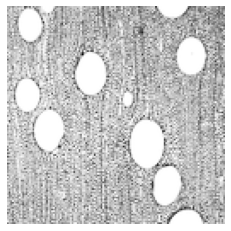

(9784, 128, 128, 1)


In [19]:
plt.imshow(x_origin[2, :, :, 0], cmap = 'Greys_r') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
np.save('labels', labels)
print(x_origin.shape)

(200,)
(200,)


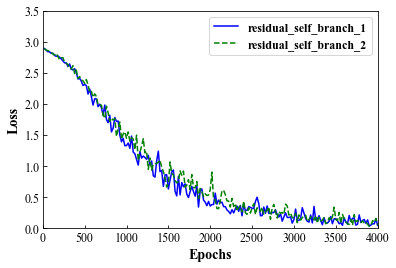

In [22]:
axis_x = np.arange(1, 200 + 1, 1)
b = np.arange(0, 4000, 20) # 从0开始间隔为10的等差数列
aa = np.load('residual_self.npy')
axis_y1 = aa[b]
print(axis_y1.shape)
print(axis_x.shape)
aa = np.load('residual_self_inception.npy')
axis_y2 = aa[b]

#print(axis_x.shape, axis_y.shape)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(axis_x * 20, axis_y1, c = 'blue', linestyle = '-', label = 'residual_self_branch_1')
plt.plot(axis_x * 20, axis_y2, c = 'green', linestyle = '--', label = 'residual_self_branch_2')
#plt.plot(axis_x * 20, axis_y3, c = 'red', linestyle = '--', label = 'residual_self_branch_3')
#plt.plot(axis_x * 20, axis_y4, c = 'c', linestyle = '--', label = 'residual_self_branch_4')
#plt.plot(axis_x * 20, axis_y5, c = 'm', linestyle = ':', label = 'Self-adapt-inception')
#plt.plot(axis_x * 10, axis_y4, c = 'blue', linestyle = ':', marker = '.', label = 'Self-adapt-3x3')

font = {'family':'Times New Roman', 'weight':'bold', 'style':'normal', 'size':12}
Lg = plt.legend(prop = font) # display lengend
font = {'family':'Times New Roman', 'weight':'bold', 'size':'larger', 'color':'black'}
plt.xlabel('Epochs', fontsize = 14, fontdict = font)
plt.ylabel('Loss', fontsize = 14, fontdict = font)
x_major_locator = MultipleLocator(500) # x axis interval setting
y_major_locator = MultipleLocator(0.5) # y axis interval setting
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xticks(fontproperties = 'Times New Roman', size = 12)
plt.yticks(fontproperties = 'Times New Roman', size = 12)
plt.ylim(0, 3.5)
plt.xlim(0, 4000)
#y_values=list(range(11))

plt.savefig('Loss_plot2.jpg', bbox_inches = 'tight')
plt.show()

In [50]:
r = 8
c = 7
w = tf.Variable(tf.truncated_normal((5, 5, 4, 9), stddev = 0.1), dtype = tf.float32, name = 'w')
print(w)
x = np.ones([7, 8, 8, 4], dtype = np.float32)
y = tf.nn.conv2d(x, w, strides = [1, 1, 1, 1], padding = "SAME", name = 'y')
#s1 = w.shape[1] - 7 + 0
print(y)
d = tf.nn.avg_pool(y, ksize = [1, 7, 7, 1], strides = [1, 2, 2, 1], padding = "VALID", name = 'd') # pooling 1 x 1
print(d)
d2 = tf.reduce_mean(d, axis = [1, 2], name = 'd2')
print(d2)
prediction = tf.nn.softmax(d2, name = 'prediction') # 判别结果
print(prediction)
#print(x.shape,x)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
result = sess.run([prediction]) # discriminator训练
print(result[0].shape)

<tf.Variable 'w_48:0' shape=(5, 5, 4, 9) dtype=float32>
Tensor("y_11:0", shape=(7, 8, 8, 9), dtype=float32)
Tensor("d_39:0", shape=(7, 1, 1, 9), dtype=float32)
Tensor("d2_1:0", shape=(7, 9), dtype=float32)
Tensor("prediction_11:0", shape=(7, 9), dtype=float32)
(7, 9)
